# import libraries

In [1]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')


Mounted at /content/drive/


In [2]:
!pip install patool
import patoolib
patoolib.extract_archive("/content/drive/My Drive/new_dataset.rar", outdir="/tmp")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 2.0 MB/s eta 0:00:00


INFO patool: Extracting /content/drive/My Drive/new_dataset.rar ...
INFO:patool:Extracting /content/drive/My Drive/new_dataset.rar ...
INFO patool: running /usr/bin/unrar x -kb -or -- "/content/drive/My Drive/new_dataset.rar"
INFO:patool:running /usr/bin/unrar x -kb -or -- "/content/drive/My Drive/new_dataset.rar"
INFO patool: ... /content/drive/My Drive/new_dataset.rar extracted to `/tmp'.
INFO:patool:... /content/drive/My Drive/new_dataset.rar extracted to `/tmp'.


'/tmp'


# RedNet30 CNN and train model

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
import torch_xla.core.xla_model as xm

# Define Dataset Class
class MRIDataset(Dataset):
    def __init__(self, sharp_dir, blur_dir, transform=None):
        self.sharp_dir = sharp_dir
        self.blur_dir = blur_dir
        self.transform = transform
        self.sharp_images = os.listdir(sharp_dir)
        self.blur_images = os.listdir(blur_dir)

    def __len__(self):
        return len(self.sharp_images)

    def __getitem__(self, idx):
        sharp_img_path = os.path.join(self.sharp_dir, self.sharp_images[idx])
        blur_img_path = os.path.join(self.blur_dir, self.blur_images[idx])

        sharp_image = Image.open(sharp_img_path).convert('L')
        blur_image = Image.open(blur_img_path).convert('L')

        if self.transform:
            sharp_image = self.transform(sharp_image)
            blur_image = self.transform(blur_image)

        return blur_image, sharp_image


# Define RedNet30 Model
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += residual
        return out

class RedNet30(nn.Module):
    def __init__(self):
        super(RedNet30, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)

        # Residual Blocks
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(64, 64) for _ in range(30)]
        )

        # Decoder
        self.conv2 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.residual_blocks(out)
        out = self.conv2(out)
        return out





In [ ]:
# Dataset Paths and Transforms
sharp_dir = '/tmp/dataset/sharped'
blur_dir = '/tmp/dataset/blurred'
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),          # Convert to tensor
])

# Create Dataset and DataLoader
batch_size = 8
dataset = MRIDataset(sharp_dir, blur_dir, transform=transform)

# TPU Preparation
def _mp_fn(rank, flags):
    torch.set_default_tensor_type('torch.FloatTensor')

    # Initialize model, optimizer, and loss function
    model = RedNet30().to(xm.xla_device())
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # DataLoader for TPU with parallel loader
    train_sampler = torch.utils.data.distributed.DistributedSampler(
        dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)

    # Parallel loader for TPU
    device_loader = pl.MpDeviceLoader(train_loader, xm.xla_device())

    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (blur_images, sharp_images) in enumerate(device_loader):
            blur_images = blur_images.to(xm.xla_device())
            sharp_images = sharp_images.to(xm.xla_device())

            # Forward pass
            outputs = model(blur_images)
            loss = criterion(outputs, sharp_images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            xm.optimizer_step(optimizer)

            running_loss += loss.item()

        # Print the loss for each epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # Save the model
    xm.save(model.state_dict(), "rednet30_mri_deblur_tpu.pth")



In [ ]:
# Start the TPU training process
FLAGS = {}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
/usr/local/lib/python3.10/dist-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
/usr/local/lib/python3.10/dist-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
/usr/local/li

Epoch [1/10], Loss: 0.2404
Epoch [1/10], Loss: 0.6883
Epoch [1/10], Loss: 0.6851
Epoch [1/10], Loss: 1.0400
Epoch [1/10], Loss: 0.2106
Epoch [1/10], Loss: 0.3621
Epoch [1/10], Loss: 0.0648
Epoch [1/10], Loss: 0.6570
Epoch [2/10], Loss: 0.0026Epoch [2/10], Loss: 0.0027Epoch [2/10], Loss: 0.0025Epoch [2/10], Loss: 0.0025Epoch [2/10], Loss: 0.0023

Epoch [2/10], Loss: 0.0029


Epoch [2/10], Loss: 0.0031
Epoch [2/10], Loss: 0.0027

Epoch [3/10], Loss: 0.0021Epoch [3/10], Loss: 0.0022Epoch [3/10], Loss: 0.0021Epoch [3/10], Loss: 0.0024Epoch [3/10], Loss: 0.0022

Epoch [3/10], Loss: 0.0022



Epoch [3/10], Loss: 0.0023Epoch [3/10], Loss: 0.0024

Epoch [4/10], Loss: 0.0021Epoch [4/10], Loss: 0.0023Epoch [4/10], Loss: 0.0020Epoch [4/10], Loss: 0.0020Epoch [4/10], Loss: 0.0021

Epoch [4/10], Loss: 0.0021



Epoch [4/10], Loss: 0.0021Epoch [4/10], Loss: 0.0023

Epoch [5/10], Loss: 0.0021Epoch [5/10], Loss: 0.0020Epoch [5/10], Loss: 0.0021Epoch [5/10], Loss: 0.0020Epoch [5/10], Loss: 0.0023Epoch 

#  test model

In [ ]:
import torch_xla.core.xla_model as xm
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
model = RedNet30().to(xm.xla_device())
model.load_state_dict(torch.load('/content/drive/My Drive/rednet30_mri_deblur_tpu.pth'))
model.eval()  # Set the model to evaluation mode


ModuleNotFoundError: No module named 'torch_xla'

In [ ]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize image to 256x256
        transforms.ToTensor(),          # Convert to tensor
    ])
    image = Image.open(image_path).convert('L')  # Open image and convert to grayscale
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image


In [ ]:
def deblur_image(model, image_path):
    # Preprocess the image
    blur_image = preprocess_image(image_path).to(xm.xla_device())

    # Deblur the image with the trained model
    with torch.no_grad():
        deblurred_image = model(blur_image).cpu().squeeze(0).squeeze(0).numpy()

    return deblurred_image


In [ ]:
import numpy as np

def display_images(blur_image_path, deblurred_image, real_image_path):
    # Load and display the blurred image
    blur_image = Image.open(blur_image_path).convert('L')
    real_image = Image.open(real_image_path).convert('L')

    # Plot the blurred and deblurred images
    plt.figure(figsize=(10, 5))

    # Display Blurred Image
    plt.subplot(1, 3, 1)
    plt.imshow(blur_image, cmap='gray')
    plt.title("Blurred Image")
    plt.axis('off')

    # Display Deblurred Image
    plt.subplot(1, 3, 2)
    plt.imshow(deblurred_image, cmap='gray')
    plt.title("Deblurred Image")
    plt.axis('off')

    # Real Image
    plt.subplot(1, 3, 3)
    plt.imshow(real_image, cmap='gray')
    plt.title("Real Image")
    plt.axis('off')

    plt.show()


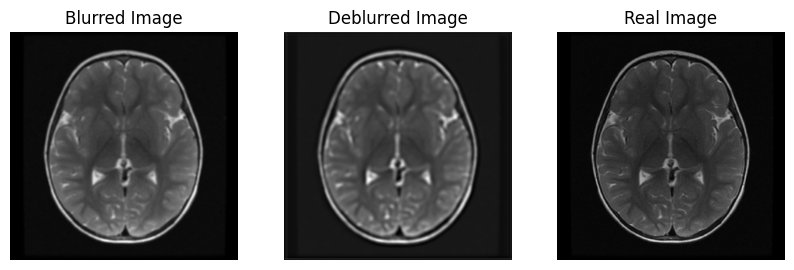

In [ ]:
# Path to the test image
test_image_path = '/tmp/dataset/blurred/2 no.jpeg'
real_image_path = '/tmp/dataset/sharped/2 no.jpeg'
# Deblur the test image
deblurred_image = deblur_image(model, test_image_path)

# Display the results
display_images(test_image_path, deblurred_image, real_image_path)


# evaluate model

In [ ]:
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
from skimage.metrics import structural_similarity as ssim

# SNR Calculation
def calculate_snr(sharp_image, deblurred_image):
    signal = np.sum(np.square(sharp_image))
    noise = np.sum(np.square(sharp_image - deblurred_image))
    snr = 10 * np.log10(signal / noise)
    return snr

# PSNR Calculation
def calculate_psnr(sharp_image, deblurred_image, max_pixel_value=255.0):
    mse = np.mean((sharp_image - deblurred_image) ** 2)
    if mse == 0:
        return float('inf')  # If MSE is 0, images are identical
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    return psnr

# SSIM Calculation
def calculate_ssim(sharp_image, deblurred_image):
    sharp_image = sharp_image.astype(np.float64)
    deblurred_image = deblurred_image.astype(np.float64)
    return ssim(sharp_image, deblurred_image, data_range=deblurred_image.max() - deblurred_image.min())

# Evaluate on a single image
def evaluate_image(model, blur_image_path, sharp_image_path):
    # Preprocess the images
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

    blur_image = Image.open(blur_image_path).convert('L')
    blur_image = transform(blur_image).unsqueeze(0)  # Add batch dimension
    blur_image = blur_image.to(torch.device('cpu'))  # or TPU if needed

    sharp_image = Image.open(sharp_image_path).convert('L')
    sharp_image = transform(sharp_image).unsqueeze(0).numpy().squeeze(0).squeeze(0)  # Remove batch dimension



    # Get deblurred image from model
    model.eval()
    with torch.no_grad():
        deblurred_image = model(blur_image).cpu().numpy().squeeze(0).squeeze(0)

    sharp_image = sharp_image * 255.0
    deblurred_image = deblurred_image * 255.0
    # Calculate Metrics
    snr_value = calculate_snr(sharp_image, deblurred_image)
    psnr_value = calculate_psnr(sharp_image, deblurred_image)
    ssim_value = calculate_ssim(sharp_image, deblurred_image)

    # Display the results
    print(f"SNR: {snr_value:.4f} dB")
    print(f"PSNR: {psnr_value:.4f} dB")
    print(f"SSIM: {ssim_value:.4f}")

# Define paths to blur and sharp images
blur_dir = '/tmp/dataset/blurred/'
sharp_dir = '/tmp/dataset/sharped/'

example_image_name = '2 no.jpeg'  # Example test image filename
blur_image_path = os.path.join(blur_dir, example_image_name)
sharp_image_path = os.path.join(sharp_dir, example_image_name)

# Load the trained model
model = RedNet30()  # Assume model is already defined
model.load_state_dict(torch.load('/content/drive/My Drive/rednet30_mri_deblur_tpu.pth'))
model.to(torch.device('cpu'))  # or 'cuda' or 'xla' for TPU

# Evaluate the test image
evaluate_image(model, blur_image_path, sharp_image_path)


<ipython-input-20-327aa6dc705b>:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/My Drive/rednet30_mri_deblur_tpu.pth'))


SNR: 15.6151 dB
PSNR: 30.5112 dB
SSIM: 0.8927


In [ ]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
from skimage.metrics import structural_similarity as ssim

# SNR Calculation
def calculate_snr(sharp_image, blurred_image):
    signal = np.sum(np.square(sharp_image))
    noise = np.sum(np.square(sharp_image - blurred_image))
    snr = 10 * np.log10(signal / noise)
    return snr

# PSNR Calculation
def calculate_psnr(sharp_image, blurred_image, max_pixel_value=255.0):
    mse = np.mean((sharp_image - blurred_image) ** 2)
    if mse == 0:
        return float('inf')  # If MSE is 0, images are identical
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    return psnr

# SSIM Calculation
def calculate_ssim(sharp_image, blurred_image):
    sharp_image = sharp_image.astype(np.float64)
    blurred_image = blurred_image.astype(np.float64)
    return ssim(sharp_image, blurred_image, data_range=blurred_image.max() - blurred_image.min())

# Evaluate on a single image
def evaluate_image(model, blur_image_path, sharp_image_path):
    # Preprocess the images
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

    # Load and preprocess the blurred image
    blur_image = Image.open(blur_image_path).convert('L')  # Convert to grayscale
    blur_image = transform(blur_image).unsqueeze(0).numpy().squeeze(0).squeeze(0)  # Convert to numpy array

    # Load and preprocess the sharp image
    sharp_image = Image.open(sharp_image_path).convert('L')  # Convert to grayscale
    sharp_image = transform(sharp_image).unsqueeze(0).numpy().squeeze(0).squeeze(0)  # Convert to numpy array

    # Convert images to range 0-255 for comparison
    sharp_image = sharp_image * 255.0
    blur_image = blur_image * 255.0

    # Calculate Metrics for the blurred image
    snr_value = calculate_snr(sharp_image, blur_image)
    psnr_value = calculate_psnr(sharp_image, blur_image)
    ssim_value = calculate_ssim(sharp_image, blur_image)

    # Display the results
    print(f"SNR (Blurred Image): {snr_value:.4f} dB")
    print(f"PSNR (Blurred Image): {psnr_value:.4f} dB")
    print(f"SSIM (Blurred Image): {ssim_value:.4f}")

# Define paths to blur and sharp images
blur_dir = '/tmp/dataset/blurred/'
sharp_dir = '/tmp/dataset/sharped/'

example_image_name = '2 no.jpeg'  # Example test image filename
blur_image_path = os.path.join(blur_dir, example_image_name)
sharp_image_path = os.path.join(sharp_dir, example_image_name)

# Load the trained model (assuming you're not using it in this case)
# model = RedNet30()  # Assume model is already defined
# model.load_state_dict(torch.load('/content/drive/My Drive/rednet30_mri_deblur_tpu.pth'))
# model.to(torch.device('cpu'))  # or 'cuda' or 'xla' for TPU

# Evaluate the test image (you can skip the model for just comparing the blurred image)
evaluate_image(None, blur_image_path, sharp_image_path)


SNR (Blurred Image): 19.2059 dB
PSNR (Blurred Image): 34.1020 dB
SSIM (Blurred Image): 0.9631


# V2

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
from torch.optim.lr_scheduler import StepLR

# Define Dataset Class
class MRIDataset(Dataset):
    def __init__(self, sharp_dir, blur_dir, transform=None):
        self.sharp_dir = sharp_dir
        self.blur_dir = blur_dir
        self.transform = transform
        self.sharp_images = os.listdir(sharp_dir)
        self.blur_images = os.listdir(blur_dir)

    def __len__(self):
        return len(self.sharp_images)

    def __getitem__(self, idx):
        sharp_img_path = os.path.join(self.sharp_dir, self.sharp_images[idx])
        blur_img_path = os.path.join(self.blur_dir, self.blur_images[idx])

        sharp_image = Image.open(sharp_img_path).convert('L')
        blur_image = Image.open(blur_img_path).convert('L')

        if self.transform:
            sharp_image = self.transform(sharp_image)
            blur_image = self.transform(blur_image)

        return blur_image, sharp_image


# Define RedNet30 Model
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += residual
        return out

class RedNet30(nn.Module):
    def __init__(self):
        super(RedNet30, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)

        # Residual Blocks
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(64, 64) for _ in range(30)]
        )

        # Decoder
        self.conv2 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.residual_blocks(out)
        out = self.conv2(out)
        return out

In [ ]:
# Dataset Paths and Transforms
sharp_dir = '/tmp/dataset/sharped'
blur_dir = '/tmp/dataset/blurred'
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),          # Convert to tensor
])

# Create Dataset and DataLoader
batch_size = 16  # Increase batch size to fully utilize TPU memory
dataset = MRIDataset(sharp_dir, blur_dir, transform=transform)

# TPU Preparation
def _mp_fn(rank, flags):
    torch.set_default_tensor_type('torch.FloatTensor')

    # Initialize model, optimizer, and loss function
    device = xm.xla_device()
    model = RedNet30().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Learning rate scheduler
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    # DataLoader for TPU with parallel loader
    train_sampler = torch.utils.data.distributed.DistributedSampler(
        dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    # Use multiple workers for faster data loading
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=8)

    # Parallel loader for TPU
    device_loader = pl.MpDeviceLoader(train_loader, device)

    num_epochs = 70
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (blur_images, sharp_images) in enumerate(device_loader):
            blur_images = blur_images.to(device)
            sharp_images = sharp_images.to(device)

            # Forward pass
            outputs = model(blur_images)
            loss = criterion(outputs, sharp_images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()

            # XLA-specific step optimizer
            xm.optimizer_step(optimizer)

            # Mark step for XLA, optimizing XLA execution
            xm.mark_step()

            running_loss += loss.item()

        # Learning rate scheduler step
        scheduler.step()

        # Print the loss for each epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # Save the model
    xm.save(model.state_dict(), "rednet30_mri_deblur_tpu.pth")

In [ ]:
# Start the TPU training process
FLAGS = {}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
/usr/local/lib/python3.10/dist-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
/usr/local/lib/python3.10/dist-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
/usr/local/li

Epoch [1/70], Loss: 2.0382Epoch [1/70], Loss: 1.2252Epoch [1/70], Loss: 0.7435Epoch [1/70], Loss: 1.1422
Epoch [1/70], Loss: 8.5070

Epoch [1/70], Loss: 0.2875Epoch [1/70], Loss: 1.4341Epoch [1/70], Loss: 0.2762




Epoch [2/70], Loss: 0.0157Epoch [2/70], Loss: 0.0204Epoch [2/70], Loss: 0.0150
Epoch [2/70], Loss: 0.0132Epoch [2/70], Loss: 0.0130


Epoch [2/70], Loss: 0.0177

Epoch [2/70], Loss: 0.0217
Epoch [2/70], Loss: 0.0187
Epoch [3/70], Loss: 0.0094Epoch [3/70], Loss: 0.0085Epoch [3/70], Loss: 0.0093Epoch [3/70], Loss: 0.0096Epoch [3/70], Loss: 0.0090Epoch [3/70], Loss: 0.0071Epoch [3/70], Loss: 0.0101


Epoch [3/70], Loss: 0.0112




Epoch [4/70], Loss: 0.0072Epoch [4/70], Loss: 0.0075Epoch [4/70], Loss: 0.0082Epoch [4/70], Loss: 0.0074Epoch [4/70], Loss: 0.0077

Epoch [4/70], Loss: 0.0061Epoch [4/70], Loss: 0.0079




Epoch [4/70], Loss: 0.0078
Epoch [5/70], Loss: 0.0068Epoch [5/70], Loss: 0.0062Epoch [5/70], Loss: 0.0069

Epoch [5/70], Loss: 0.0055Epoch [5/70], Loss: 0.0067Epoc

# V3

Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 160ms/step - loss: 0.1643 - val_loss: 0.1536
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - loss: 0.1506 - val_loss: 0.1499
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.1553 - val_loss: 0.1475
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.1434 - val_loss: 0.1479
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.1429 - val_loss: 0.1452
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 0.1434 - val_loss: 0.1431
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.1398 - val_loss: 0.1421
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.1367 - val_loss: 0.1471
Epoch 9/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 0.1427 - val_loss: 0.1399
Epoch 10/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.1394 - val_loss: 0.1397
Epoch 11/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.1377 - val_loss: 0.1377
Epoch 12/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 

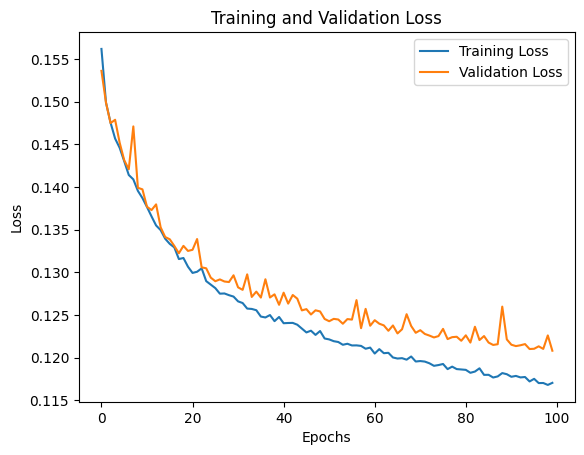

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Function to build the Residual CNN
def build_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Layer 1: Convolution with ReLU
    x = layers.Conv2D(128, kernel_size=(9, 9), activation='relu', padding='same')(inputs)
    # Layer 2: Convolution with ReLU
    x = layers.Conv2D(64, kernel_size=(9, 9), activation='relu', padding='same')(x)
    x = layers.Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same')(x)
    # Layer 3: Convolution with Linear Activation
    x = layers.Conv2D(2, kernel_size=(1, 1), activation=None, padding='same')(x)

    # Add skip connection
    outputs = layers.Add()([inputs, x])

    # Define model
    model = models.Model(inputs, outputs)
    return model

# Custom gradient difference loss
def gradient_difference_loss(y_true, y_pred):
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    grad_diff = tf.abs(dy_true - dy_pred) + tf.abs(dx_true - dx_pred)
    return tf.reduce_mean(grad_diff)

# Combined loss
def combined_loss(y_true, y_pred):
    l1_loss = tf.reduce_mean(tf.abs(y_true - y_pred))
    grad_loss = gradient_difference_loss(y_true, y_pred)
    return l1_loss + grad_loss

# Load dataset
def load_data(blurred_folder, sharp_folder, img_size=(84, 84)):
    def load_images(folder):
        images = []
        for filename in sorted(os.listdir(folder)):
            filepath = os.path.join(folder, filename)
            img = tf.keras.utils.load_img(filepath, target_size=img_size, color_mode='grayscale')
            img_array = tf.keras.utils.img_to_array(img) / 255.0  # Normalize to [0, 1]
            images.append(img_array)
        return np.array(images)

    blurred_images = load_images(blurred_folder)
    sharp_images = load_images(sharp_folder)

    # Ensure consistent shape
    blurred_images = blurred_images[..., np.newaxis] if blurred_images.ndim == 3 else blurred_images
    sharp_images = sharp_images[..., np.newaxis] if sharp_images.ndim == 3 else sharp_images

    # Combine real and imaginary channels if needed
    return blurred_images, sharp_images

# Paths to blurred and sharp image folders
blurred_folder = "/tmp/dataset/blurred"
sharp_folder = "/tmp/dataset/sharped"

# Load data
blurred_images, sharp_images = load_data(blurred_folder, sharp_folder)

# Split data
X_train, X_temp, Y_train, Y_temp = train_test_split(blurred_images, sharp_images, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# Build and compile the model
input_shape = (84, 84, 1)
model = build_model(input_shape)
model.compile(optimizer='adam', loss=combined_loss)

# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100, batch_size=16
)

# Save the model
model.save("residual_cnn_model.h5")

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step


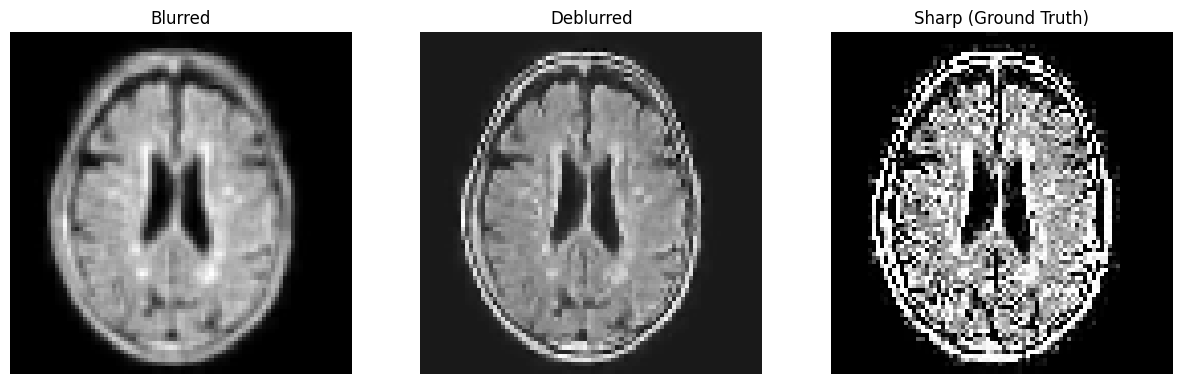

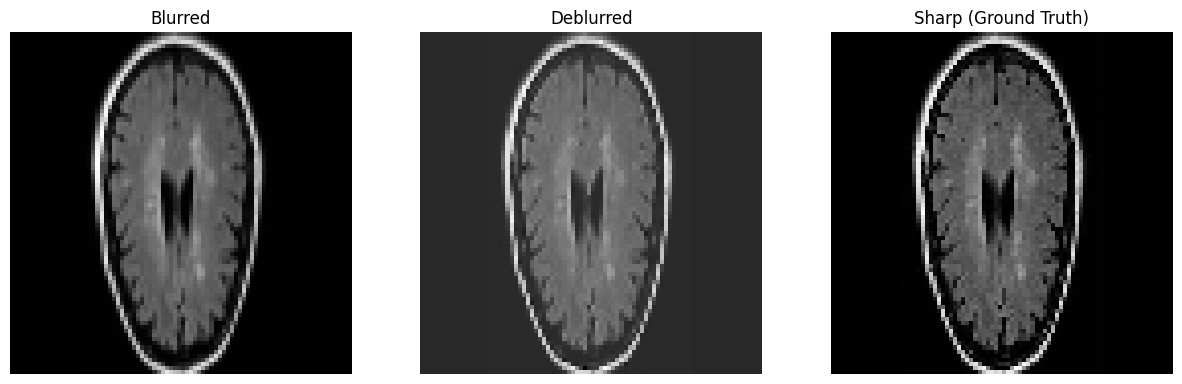

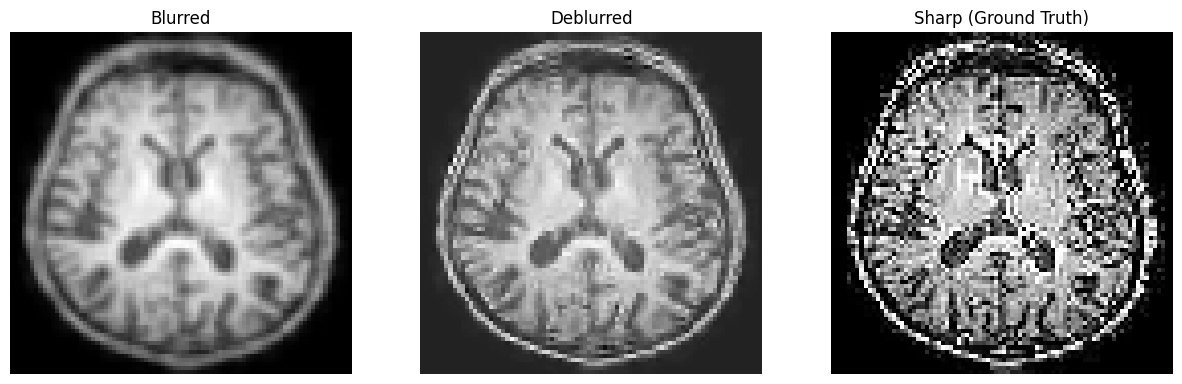

In [ ]:
# Load the saved model
from tensorflow.keras.models import load_model

# Load model with the custom loss
model = load_model("residual_cnn_model.h5", custom_objects={'combined_loss': combined_loss})

# Predict on test data
predicted_images = model.predict(X_test)

# Function to display blurred, deblurred, and sharp images
def display_images(blurred, deblurred, sharp, index=0):
    plt.figure(figsize=(15, 5))

    # Blurred image
    plt.subplot(1, 3, 1)
    plt.title("Blurred")
    plt.imshow(blurred[index, :, :, 0], cmap='gray')
    plt.axis('off')

    # Deblurred image
    plt.subplot(1, 3, 2)
    plt.title("Deblurred")
    plt.imshow(deblurred[index, :, :, 0], cmap='gray')
    plt.axis('off')

    # Sharp image
    plt.subplot(1, 3, 3)
    plt.title("Sharp (Ground Truth)")
    plt.imshow(sharp[index, :, :, 0], cmap='gray')
    plt.axis('off')

    plt.show()

# Visualize results
for i in range(3):  # Show first 3 test samples
    display_images(X_test, predicted_images, Y_test, index=i)


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Compute PSNR and SSIM for test data
def evaluate_model(y_true, y_pred):
    psnr_values = [psnr(y_true[i, ..., 0], y_pred[i, ..., 0], data_range=1.0) for i in range(len(y_true))]
    ssim_values = [ssim(y_true[i, ..., 0], y_pred[i, ..., 0], data_range=1.0) for i in range(len(y_true))]

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    print(f"Average PSNR: {avg_psnr:.2f}")
    print(f"Average SSIM: {avg_ssim:.4f}")

# Evaluate on test data
evaluate_model(Y_test, predicted_images)


Average PSNR: 25.76
Average SSIM: 0.8887


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Compute PSNR and SSIM for test data
def evaluate_model(y_true, y_pred):
    psnr_values = [psnr(y_true[i, ..., 0], y_pred[i, ..., 0], data_range=1.0) for i in range(len(y_true))]
    ssim_values = [ssim(y_true[i, ..., 0], y_pred[i, ..., 0], data_range=1.0) for i in range(len(y_true))]

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    print(f"Average PSNR: {avg_psnr:.2f}")
    print(f"Average SSIM: {avg_ssim:.4f}")

# Evaluate on test data
evaluate_model(Y_test, X_test)


Average PSNR: 22.57
Average SSIM: 0.8000


# V4 (SRResCycGAN)

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array


def load_images(blurred_folder, shaped_folder, target_size=(256, 256)):
    """
    Loads the blurred and shaped images from their respective folders.

    Parameters:
        blurred_folder: Path to the folder containing blurred images.
        shaped_folder: Path to the folder containing sharp images.
        target_size: The size to which each image will be resized.

    Returns:
        Two NumPy arrays: one for blurred images and one for sharp images.
    """
    blurred_images, shaped_images = [], []

    # Get sorted filenames
    blurred_filenames = sorted(os.listdir(blurred_folder))
    shaped_filenames = sorted(os.listdir(shaped_folder))

    assert blurred_filenames == shaped_filenames, "Filenames must match!"

    for filename in blurred_filenames:
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            # Load and preprocess blurred image
            blurred_path = os.path.join(blurred_folder, filename)
            blurred_img = img_to_array(load_img(blurred_path, target_size=target_size)) / 255.0
            blurred_images.append(blurred_img)

            # Load and preprocess shaped image
            shaped_path = os.path.join(shaped_folder, filename)
            shaped_img = img_to_array(load_img(shaped_path, target_size=target_size)) / 255.0
            shaped_images.append(shaped_img)

    return np.array(blurred_images), np.array(shaped_images)

# Paths to the dataset folders
blurred_folder = "/tmp/dataset/blurred"
shaped_folder = "/tmp/dataset/sharped"

# Load the images
blurred_images, shaped_images = load_images(blurred_folder, shaped_folder)

# Print shapes to confirm loading
print(f"Blurred images shape: {blurred_images.shape}")
print(f"Shaped images shape: {shaped_images.shape}")


Blurred images shape: (2105, 256, 256, 3)
Shaped images shape: (2105, 256, 256, 3)


In [ ]:
from sklearn.model_selection import train_test_split

# Train-test split
train_blurred, test_blurred, train_shaped, test_shaped = train_test_split(
    blurred_images, shaped_images, test_size=0.2, random_state=42
)


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.layers import Input, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU, Flatten, Dense
import tensorflow as tf

def residual_block(input_tensor, filters=64, kernel_size=3):
    """
    Defines a single residual block.

    Parameters:
        input_tensor: Input tensor to the residual block.
        filters: Number of filters for the convolution layers.
        kernel_size: Kernel size for the convolution layers.

    Returns:
        Tensor after passing through the residual block.
    """
    x = Conv2D(filters, kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    return Add()([input_tensor, x])  # Skip connection


def build_generator(input_shape=(256, 256, 3), num_res_blocks=16):
    """
    Builds the generator model for SRResCycGAN.

    Parameters:
        input_shape: Shape of the input image.
        num_res_blocks: Number of residual blocks in the generator.

    Returns:
        Generator model.
    """
    inputs = Input(shape=input_shape)

    # Initial Convolution
    x = Conv2D(64, 9, padding="same", activation="relu")(inputs)
    skip_connection = x  # Store this for adding later

    # Residual Blocks
    for _ in range(num_res_blocks):
        x = residual_block(x)

    # Add Skip Connection
    x = Add()([x, skip_connection])

    # Upsampling Layers
    # for _ in range(2):  # Upsample by 4x (2x2)
    #     x = Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)

    # Output Layer
    outputs = Conv2D(3, 9, padding="same", activation="tanh")(x)

    return Model(inputs, outputs, name="Generator")



def build_discriminator(input_shape=(256, 256, 3)):
    """
    Builds the discriminator model for SRResCycGAN.

    Parameters:
        input_shape: Shape of the input image.

    Returns:
        Discriminator model.
    """
    inputs = Input(shape=input_shape)

    x = Conv2D(64, 3, strides=1, padding="same")(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    # Downsampling Layers
    for filters in [64, 128, 128, 256, 256]:
        x = Conv2D(filters, 3, strides=2, padding="same")(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

    # Fully Connected Layers
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    outputs = Dense(1, activation="sigmoid")(x)

    return Model(inputs, outputs, name="Discriminator")



def cycle_consistency_loss(real_image, cycled_image):
    """
    Computes cycle consistency loss.

    Parameters:
        real_image: The original input image.
        cycled_image: The image after a forward and backward pass.

    Returns:
        Cycle consistency loss.
    """
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

class SRResCycGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, lambda_cycle=10.0):
        """
        Initializes the SRResCycGAN model.

        Parameters:
            generator: Generator model.
            discriminator: Discriminator model.
            lambda_cycle: Weight for the cycle-consistency loss.
        """
        super(SRResCycGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.lambda_cycle = lambda_cycle

    def compile(self, generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss):
        """
        Compiles the model with optimizers and losses.

        Parameters:
            generator_optimizer: Optimizer for the generator.
            discriminator_optimizer: Optimizer for the discriminator.
            generator_loss: Loss function for the generator.
            discriminator_loss: Loss function for the discriminator.
        """
        super(SRResCycGAN, self).compile()
        self.gen_optimizer = generator_optimizer
        self.disc_optimizer = discriminator_optimizer
        self.gen_loss_fn = generator_loss
        self.disc_loss_fn = discriminator_loss

    def train_step(self, data):
        blurred_images, real_shaped_images = data

        # Train generator
        with tf.GradientTape() as gen_tape:
            fake_shaped_images = self.generator(blurred_images, training=True)
            cycle_blurred_images = self.generator(fake_shaped_images, training=True)

            # Generator loss
            gen_loss = self.gen_loss_fn(real_shaped_images, fake_shaped_images)
            cycle_loss = cycle_consistency_loss(blurred_images, cycle_blurred_images)
            total_gen_loss = gen_loss + self.lambda_cycle * cycle_loss

        gen_gradients = gen_tape.gradient(total_gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))

        # Train discriminator
        with tf.GradientTape() as disc_tape:
            real_output = self.discriminator(real_shaped_images, training=True)
            fake_output = self.discriminator(fake_shaped_images, training=True)

            disc_loss = self.disc_loss_fn(real_output, fake_output)

        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))

        return {"gen_loss": total_gen_loss, "disc_loss": disc_loss}



In [ ]:
# Import the SRResCycGAN implementation
from tensorflow.keras.models import Model

# Build generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

# Initialize your SRResCycGAN model
srrescycgan_model = SRResCycGAN(generator, discriminator)

# Compile the model
srrescycgan_model.compile(
    generator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    generator_loss=tf.keras.losses.MeanSquaredError(),
    discriminator_loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)





In [ ]:
train_blurred.shape

(1684, 256, 256, 3)

In [ ]:
from sklearn.model_selection import train_test_split
train_blurred, test_blurred, train_shaped, test_shaped = train_test_split(
    blurred_images, shaped_images, test_size=0.2, random_state=42
)
def create_tf_dataset(inputs, targets, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))
    return dataset.shuffle(len(inputs)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_dataset = create_tf_dataset(train_blurred, train_shaped)
test_dataset = create_tf_dataset(test_blurred, test_shaped)

In [ ]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [ ]:
# Train the model
srrescycgan_model.fit(train_dataset, epochs=50, validation_data=test_dataset)
srrescycgan.save("srrescycgan_model")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


  1/106 [..............................] - ETA: 11:44:50 - gen_loss: 10.0449 - disc_loss: 0.8287

KeyboardInterrupt: 

# V5(MPRNet)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pdb import set_trace as stx

##########################################################################
def conv(in_channels, out_channels, kernel_size, bias=False, stride = 1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias, stride = stride)


##########################################################################
## Channel Attention Layer
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16, bias=False):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
                nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=bias),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=bias),
                nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y


##########################################################################
## Channel Attention Block (CAB)
class CAB(nn.Module):
    def __init__(self, n_feat, kernel_size, reduction, bias, act):
        super(CAB, self).__init__()
        modules_body = []
        modules_body.append(conv(n_feat, n_feat, kernel_size, bias=bias))
        modules_body.append(act)
        modules_body.append(conv(n_feat, n_feat, kernel_size, bias=bias))

        self.CA = CALayer(n_feat, reduction, bias=bias)
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res = self.CA(res)
        res += x
        return res

##########################################################################
## Supervised Attention Module
class SAM(nn.Module):
    def __init__(self, n_feat, kernel_size, bias):
        super(SAM, self).__init__()
        self.conv1 = conv(n_feat, n_feat, kernel_size, bias=bias)
        self.conv2 = conv(n_feat, 3, kernel_size, bias=bias)
        self.conv3 = conv(3, n_feat, kernel_size, bias=bias)

    def forward(self, x, x_img):
        x1 = self.conv1(x)
        img = self.conv2(x) + x_img
        x2 = torch.sigmoid(self.conv3(img))
        x1 = x1*x2
        x1 = x1+x
        return x1, img

##########################################################################
## U-Net

class Encoder(nn.Module):
    def __init__(self, n_feat, kernel_size, reduction, act, bias, scale_unetfeats, csff):
        super(Encoder, self).__init__()

        self.encoder_level1 = [CAB(n_feat,                     kernel_size, reduction, bias=bias, act=act) for _ in range(2)]
        self.encoder_level2 = [CAB(n_feat+scale_unetfeats,     kernel_size, reduction, bias=bias, act=act) for _ in range(2)]
        self.encoder_level3 = [CAB(n_feat+(scale_unetfeats*2), kernel_size, reduction, bias=bias, act=act) for _ in range(2)]

        self.encoder_level1 = nn.Sequential(*self.encoder_level1)
        self.encoder_level2 = nn.Sequential(*self.encoder_level2)
        self.encoder_level3 = nn.Sequential(*self.encoder_level3)

        self.down12  = DownSample(n_feat, scale_unetfeats)
        self.down23  = DownSample(n_feat+scale_unetfeats, scale_unetfeats)

        # Cross Stage Feature Fusion (CSFF)
        if csff:
            self.csff_enc1 = nn.Conv2d(n_feat,                     n_feat,                     kernel_size=1, bias=bias)
            self.csff_enc2 = nn.Conv2d(n_feat+scale_unetfeats,     n_feat+scale_unetfeats,     kernel_size=1, bias=bias)
            self.csff_enc3 = nn.Conv2d(n_feat+(scale_unetfeats*2), n_feat+(scale_unetfeats*2), kernel_size=1, bias=bias)

            self.csff_dec1 = nn.Conv2d(n_feat,                     n_feat,                     kernel_size=1, bias=bias)
            self.csff_dec2 = nn.Conv2d(n_feat+scale_unetfeats,     n_feat+scale_unetfeats,     kernel_size=1, bias=bias)
            self.csff_dec3 = nn.Conv2d(n_feat+(scale_unetfeats*2), n_feat+(scale_unetfeats*2), kernel_size=1, bias=bias)

    def forward(self, x, encoder_outs=None, decoder_outs=None):
        enc1 = self.encoder_level1(x)
        if (encoder_outs is not None) and (decoder_outs is not None):
            enc1 = enc1 + self.csff_enc1(encoder_outs[0]) + self.csff_dec1(decoder_outs[0])

        x = self.down12(enc1)

        enc2 = self.encoder_level2(x)
        if (encoder_outs is not None) and (decoder_outs is not None):
            enc2 = enc2 + self.csff_enc2(encoder_outs[1]) + self.csff_dec2(decoder_outs[1])

        x = self.down23(enc2)

        enc3 = self.encoder_level3(x)
        if (encoder_outs is not None) and (decoder_outs is not None):
            enc3 = enc3 + self.csff_enc3(encoder_outs[2]) + self.csff_dec3(decoder_outs[2])

        return [enc1, enc2, enc3]

class Decoder(nn.Module):
    def __init__(self, n_feat, kernel_size, reduction, act, bias, scale_unetfeats):
        super(Decoder, self).__init__()

        self.decoder_level1 = [CAB(n_feat,                     kernel_size, reduction, bias=bias, act=act) for _ in range(2)]
        self.decoder_level2 = [CAB(n_feat+scale_unetfeats,     kernel_size, reduction, bias=bias, act=act) for _ in range(2)]
        self.decoder_level3 = [CAB(n_feat+(scale_unetfeats*2), kernel_size, reduction, bias=bias, act=act) for _ in range(2)]

        self.decoder_level1 = nn.Sequential(*self.decoder_level1)
        self.decoder_level2 = nn.Sequential(*self.decoder_level2)
        self.decoder_level3 = nn.Sequential(*self.decoder_level3)

        self.skip_attn1 = CAB(n_feat,                 kernel_size, reduction, bias=bias, act=act)
        self.skip_attn2 = CAB(n_feat+scale_unetfeats, kernel_size, reduction, bias=bias, act=act)

        self.up21  = SkipUpSample(n_feat, scale_unetfeats)
        self.up32  = SkipUpSample(n_feat+scale_unetfeats, scale_unetfeats)

    def forward(self, outs):
        enc1, enc2, enc3 = outs
        dec3 = self.decoder_level3(enc3)

        x = self.up32(dec3, self.skip_attn2(enc2))
        dec2 = self.decoder_level2(x)

        x = self.up21(dec2, self.skip_attn1(enc1))
        dec1 = self.decoder_level1(x)

        return [dec1,dec2,dec3]

##########################################################################
##---------- Resizing Modules ----------
class DownSample(nn.Module):
    def __init__(self, in_channels,s_factor):
        super(DownSample, self).__init__()
        self.down = nn.Sequential(nn.Upsample(scale_factor=0.5, mode='bilinear', align_corners=False),
                                  nn.Conv2d(in_channels, in_channels+s_factor, 1, stride=1, padding=0, bias=False))

    def forward(self, x):
        x = self.down(x)
        return x

class UpSample(nn.Module):
    def __init__(self, in_channels,s_factor):
        super(UpSample, self).__init__()
        self.up = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                                nn.Conv2d(in_channels+s_factor, in_channels, 1, stride=1, padding=0, bias=False))

    def forward(self, x):
        x = self.up(x)
        return x

class SkipUpSample(nn.Module):
    def __init__(self, in_channels,s_factor):
        super(SkipUpSample, self).__init__()
        self.up = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                                nn.Conv2d(in_channels+s_factor, in_channels, 1, stride=1, padding=0, bias=False))

    def forward(self, x, y):
        x = self.up(x)
        x = x + y
        return x

##########################################################################
## Original Resolution Block (ORB)
class ORB(nn.Module):
    def __init__(self, n_feat, kernel_size, reduction, act, bias, num_cab):
        super(ORB, self).__init__()
        modules_body = []
        modules_body = [CAB(n_feat, kernel_size, reduction, bias=bias, act=act) for _ in range(num_cab)]
        modules_body.append(conv(n_feat, n_feat, kernel_size))
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res

##########################################################################
class ORSNet(nn.Module):
    def __init__(self, n_feat, scale_orsnetfeats, kernel_size, reduction, act, bias, scale_unetfeats, num_cab):
        super(ORSNet, self).__init__()

        self.orb1 = ORB(n_feat+scale_orsnetfeats, kernel_size, reduction, act, bias, num_cab)
        self.orb2 = ORB(n_feat+scale_orsnetfeats, kernel_size, reduction, act, bias, num_cab)
        self.orb3 = ORB(n_feat+scale_orsnetfeats, kernel_size, reduction, act, bias, num_cab)

        self.up_enc1 = UpSample(n_feat, scale_unetfeats)
        self.up_dec1 = UpSample(n_feat, scale_unetfeats)

        self.up_enc2 = nn.Sequential(UpSample(n_feat+scale_unetfeats, scale_unetfeats), UpSample(n_feat, scale_unetfeats))
        self.up_dec2 = nn.Sequential(UpSample(n_feat+scale_unetfeats, scale_unetfeats), UpSample(n_feat, scale_unetfeats))

        self.conv_enc1 = nn.Conv2d(n_feat, n_feat+scale_orsnetfeats, kernel_size=1, bias=bias)
        self.conv_enc2 = nn.Conv2d(n_feat, n_feat+scale_orsnetfeats, kernel_size=1, bias=bias)
        self.conv_enc3 = nn.Conv2d(n_feat, n_feat+scale_orsnetfeats, kernel_size=1, bias=bias)

        self.conv_dec1 = nn.Conv2d(n_feat, n_feat+scale_orsnetfeats, kernel_size=1, bias=bias)
        self.conv_dec2 = nn.Conv2d(n_feat, n_feat+scale_orsnetfeats, kernel_size=1, bias=bias)
        self.conv_dec3 = nn.Conv2d(n_feat, n_feat+scale_orsnetfeats, kernel_size=1, bias=bias)

    def forward(self, x, encoder_outs, decoder_outs):
        x = self.orb1(x)
        x = x + self.conv_enc1(encoder_outs[0]) + self.conv_dec1(decoder_outs[0])

        x = self.orb2(x)
        x = x + self.conv_enc2(self.up_enc1(encoder_outs[1])) + self.conv_dec2(self.up_dec1(decoder_outs[1]))

        x = self.orb3(x)
        x = x + self.conv_enc3(self.up_enc2(encoder_outs[2])) + self.conv_dec3(self.up_dec2(decoder_outs[2]))

        return x


##########################################################################
class MPRNet(nn.Module):
    def __init__(self, in_c=3, out_c=3, n_feat=96, scale_unetfeats=48, scale_orsnetfeats=32, num_cab=8, kernel_size=3, reduction=4, bias=False):
        super(MPRNet, self).__init__()

        act=nn.PReLU()
        self.shallow_feat1 = nn.Sequential(conv(in_c, n_feat, kernel_size, bias=bias), CAB(n_feat,kernel_size, reduction, bias=bias, act=act))
        self.shallow_feat2 = nn.Sequential(conv(in_c, n_feat, kernel_size, bias=bias), CAB(n_feat,kernel_size, reduction, bias=bias, act=act))
        self.shallow_feat3 = nn.Sequential(conv(in_c, n_feat, kernel_size, bias=bias), CAB(n_feat,kernel_size, reduction, bias=bias, act=act))

        # Cross Stage Feature Fusion (CSFF)
        self.stage1_encoder = Encoder(n_feat, kernel_size, reduction, act, bias, scale_unetfeats, csff=False)
        self.stage1_decoder = Decoder(n_feat, kernel_size, reduction, act, bias, scale_unetfeats)

        self.stage2_encoder = Encoder(n_feat, kernel_size, reduction, act, bias, scale_unetfeats, csff=True)
        self.stage2_decoder = Decoder(n_feat, kernel_size, reduction, act, bias, scale_unetfeats)

        self.stage3_orsnet = ORSNet(n_feat, scale_orsnetfeats, kernel_size, reduction, act, bias, scale_unetfeats, num_cab)

        self.sam12 = SAM(n_feat, kernel_size=1, bias=bias)
        self.sam23 = SAM(n_feat, kernel_size=1, bias=bias)

        self.concat12  = conv(n_feat*2, n_feat, kernel_size, bias=bias)
        self.concat23  = conv(n_feat*2, n_feat+scale_orsnetfeats, kernel_size, bias=bias)
        self.tail     = conv(n_feat+scale_orsnetfeats, out_c, kernel_size, bias=bias)

    def forward(self, x3_img):
        # Original-resolution Image for Stage 3
        H = x3_img.size(2)
        W = x3_img.size(3)

        # Multi-Patch Hierarchy: Split Image into four non-overlapping patches

        # Two Patches for Stage 2
        x2top_img  = x3_img[:,:,0:int(H/2),:]
        x2bot_img  = x3_img[:,:,int(H/2):H,:]

        # Four Patches for Stage 1
        x1ltop_img = x2top_img[:,:,:,0:int(W/2)]
        x1rtop_img = x2top_img[:,:,:,int(W/2):W]
        x1lbot_img = x2bot_img[:,:,:,0:int(W/2)]
        x1rbot_img = x2bot_img[:,:,:,int(W/2):W]

        ##-------------------------------------------
        ##-------------- Stage 1---------------------
        ##-------------------------------------------
        ## Compute Shallow Features
        x1ltop = self.shallow_feat1(x1ltop_img)
        x1rtop = self.shallow_feat1(x1rtop_img)
        x1lbot = self.shallow_feat1(x1lbot_img)
        x1rbot = self.shallow_feat1(x1rbot_img)

        ## Process features of all 4 patches with Encoder of Stage 1
        feat1_ltop = self.stage1_encoder(x1ltop)
        feat1_rtop = self.stage1_encoder(x1rtop)
        feat1_lbot = self.stage1_encoder(x1lbot)
        feat1_rbot = self.stage1_encoder(x1rbot)

        ## Concat deep features
        feat1_top = [torch.cat((k,v), 3) for k,v in zip(feat1_ltop,feat1_rtop)]
        feat1_bot = [torch.cat((k,v), 3) for k,v in zip(feat1_lbot,feat1_rbot)]

        ## Pass features through Decoder of Stage 1
        res1_top = self.stage1_decoder(feat1_top)
        res1_bot = self.stage1_decoder(feat1_bot)

        ## Apply Supervised Attention Module (SAM)
        x2top_samfeats, stage1_img_top = self.sam12(res1_top[0], x2top_img)
        x2bot_samfeats, stage1_img_bot = self.sam12(res1_bot[0], x2bot_img)

        ## Output image at Stage 1
        stage1_img = torch.cat([stage1_img_top, stage1_img_bot],2)
        ##-------------------------------------------
        ##-------------- Stage 2---------------------
        ##-------------------------------------------
        ## Compute Shallow Features
        x2top  = self.shallow_feat2(x2top_img)
        x2bot  = self.shallow_feat2(x2bot_img)

        ## Concatenate SAM features of Stage 1 with shallow features of Stage 2
        x2top_cat = self.concat12(torch.cat([x2top, x2top_samfeats], 1))
        x2bot_cat = self.concat12(torch.cat([x2bot, x2bot_samfeats], 1))

        ## Process features of both patches with Encoder of Stage 2
        feat2_top = self.stage2_encoder(x2top_cat, feat1_top, res1_top)
        feat2_bot = self.stage2_encoder(x2bot_cat, feat1_bot, res1_bot)

        ## Concat deep features
        feat2 = [torch.cat((k,v), 2) for k,v in zip(feat2_top,feat2_bot)]

        ## Pass features through Decoder of Stage 2
        res2 = self.stage2_decoder(feat2)

        ## Apply SAM
        x3_samfeats, stage2_img = self.sam23(res2[0], x3_img)


        ##-------------------------------------------
        ##-------------- Stage 3---------------------
        ##-------------------------------------------
        ## Compute Shallow Features
        x3     = self.shallow_feat3(x3_img)

        ## Concatenate SAM features of Stage 2 with shallow features of Stage 3
        x3_cat = self.concat23(torch.cat([x3, x3_samfeats], 1))

        x3_cat = self.stage3_orsnet(x3_cat, feat2, res2)

        stage3_img = self.tail(x3_cat)

        return [stage3_img+x3_img, stage2_img, stage1_img]

In [4]:
import torch
import torch.nn as nn
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.utils.utils as xu
import torch_xla.distributed.xla_multiprocessing as xmp
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

/usr/local/lib/python3.10/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


In [5]:

BATCH_SIZE = 16  # TPU prefers larger batch sizes for better utilization
LEARNING_RATE = 1e-4
EPOCHS = 20
DATA_DIR = "/tmp/dataset/"  # Update this to your dataset path


In [6]:
# Define Dataset
class MRIDataset(torch.utils.data.Dataset):
    def __init__(self, blur_folder, sharp_folder, transform=None):
        self.blur_images = sorted(list(blur_folder))
        self.sharp_images = sorted(list(sharp_folder))
        self.transform = transform

    def __len__(self):
        return len(self.blur_images)

    def __getitem__(self, idx):
        blurred = Image.open(self.blur_images[idx]).convert("RGB")
        sharp = Image.open(self.sharp_images[idx]).convert("RGB")
        if self.transform:
            blurred = self.transform(blurred)
            sharp = self.transform(sharp)
        return blurred, sharp

In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [8]:
train_dataset = MRIDataset(DATA_DIR + '/blurred', DATA_DIR + '/sharped', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
# Define model, optimizer, and loss function
def train(rank, flags):
    # Setup TPU device
    device = xm.xla_device()

    # Initialize model, optimizer, and loss function
    model = MPRNet()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()

    # Prepare DataLoader for TPU
    train_loader_tpu = pl.MpDeviceLoader(train_loader, device)

    # Training loop
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for step, (inputs, targets) in enumerate(train_loader_tpu):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)[0]  # Get Stage 3 output
            loss = criterion(outputs, targets)

            loss.backward()
            xm.optimizer_step(optimizer)

            total_loss += loss.item()

            if step % 10 == 0:
                xm.master_print(f"Epoch {epoch+1}/{EPOCHS}, Step {step}/{len(train_loader)}, Loss: {loss.item()}")

        xm.master_print(f"Epoch {epoch+1} finished with average loss: {total_loss/len(train_loader)}")

    # Save model
    xm.save(model.state_dict(), "mprnet_tpu.pth")


In [ ]:
# Run training across TPU cores
flags = {}
xmp.spawn(train, args=(flags,), nprocs=8, start_method="fork")